In [2]:
include("NTKernel.jl");

In [31]:
# PSUDEO data
g = x -> cos(2x)+sin(x/2)           # anonymous function g(x)

X = range(1, stop=12, length=70)
X = Matrix(reshape(X, 1, :))        # reshape, each column vector is read as data point

Y = map(g,X);                       # Map with g(x)

In [3]:
# nodes on hidden layer
Nh = 100
InputDim = 1
activation = sigmoid

model = Chain(Dense(InputDim=>Nh,activation),Dense(Nh=>InputDim))|>f64

K = kernel(model, X)
normalized_K = K / sqrt(Nh) # Normalize the kernel matrix

λ_values = eigen(normalized_K).values;

In [4]:
Ý = map_model(model,X); # Evaluates all X points, and takes dims into account 😍

In [32]:
using Plots

# The subplot simplified
function graph(model, x, y, λ, logplot=false) # specify if logplotted eigenvalues
    ý = map_model(model, x)

    # Create subplots
    plot1 = scatter(x[:], y[:], label="Real data", xlabel="X", ylabel="Y", yaxis=:identity)
    scatter!(x[:], ý[:], label="Estimated data")

    # Conditional y-axis scaling based on logplot
    plot2 = scatter(1:length(λ), λ, label="Eigenvalue", xlabel="Id. Eigenvalue", ylabel="Eigenvalue", yaxis=logplot ? :log10 : :identity)

    # Combine subplots into a single plot
    plot(plot1, plot2)
end 

graph (generic function with 2 methods)

<h3>Beware!!!</h3> 

After the yaxis is changed, you shouldn't change it back. Then the plot function seems to stop working. <br>
This might be a bug with the Plog package?

<h1> Now, lets start tinkering with the models </h1>

In [33]:
# nodes on hidden layer

function create_model(Ni, Nh, No, N, activation)
    layers = [] # Initialize an empty array without specifying the type of elements
    push!(layers, Dense(Ni, N, activation)) # First hidden layer with N nodes and specified activation
    for _ in 2:Nh
        push!(layers, Dense(N, N, activation)) # Additional Nh-1 hidden layers
    end
    push!(layers, Dense(N, No)) # Output layer without specifying an activation function (defaults to identity)
    model = Chain(layers...)|>f64 # Create the model from the layers
    return model
end


Nh_list = [100, 1000] 
H_Layers = [1]
models = []
activation = sigmoid

InputDim = 1

models = []
for Nh in 1:length(Nh_list)
    for Layer in 1:length(H_Layers)
        push!(models, create_model(InputDim,H_Layers[Layer],InputDim,Nh_list[Nh],activation))
    end
end

Kernels = []
for model in models
    push!(Kernels, kernel(model, X))
end

Kernels_Norms = []
# Iterate over each kernel and normalize according to your pattern
for i in 1:length(Kernels)
    # Use mod1 to cycle through Nh_list based on i
    # This approach correctly associates each kernel with its Nh value according to your pattern
    Nh_index = mod1(i, length(Nh_list))
    Nh = Nh_list[Nh_index]
    normalized_K = Kernels[i] / sqrt(Nh)
    push!(Kernels_Norms, normalized_K)
end
λ_values = []
for K in Kernels_Norms
    push!(λ_values, eigen(K).values) # Compute eigenvalues for each kernel and store
end


# loss(a, b) = Flux.Losses.mse(models[1](a), b)
#Flux.train!(loss, Flux.params(models[1]), [(X,Y)], Descent(0.01))

In [34]:
# for i in 1:length(models)
#     display(models[i])
# end

loss(model, x, y) = Flux.Losses.mse(model(x),y)

opt = Descent(1/265)
data = [(X, Y)]
Nepoch=200000
for epoch=1:Nepoch
    Flux.train!(loss, models[1], data, opt)
end




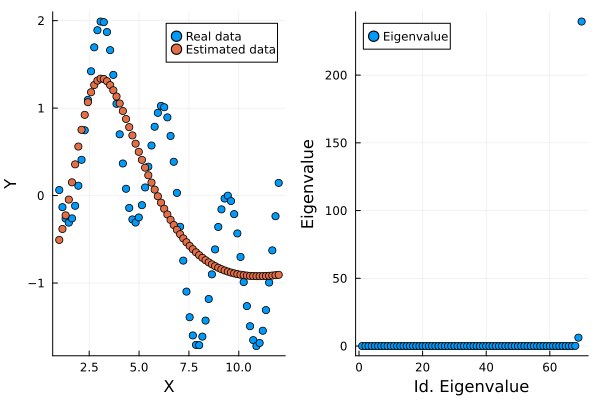

In [35]:
graph(models[2], X, Y, λ_values[1])
# 30s

# savefig("REAL_EST_TES.png")